## Problem 1

Consider a convection/diffusion problem that has Dirichlet conditions on temperature imposed on both ends (see the figure below). This is an unusual problem that would be difficult to reproduce in a laboratory, but it is an interesting problem by which to observe the performance of advection schemes.

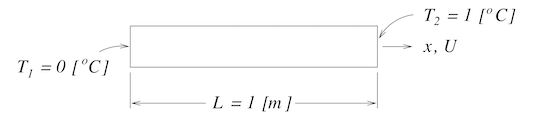
   
The exact solution to this problem is given by:

$$
    T(x)= T_1 + \frac{e^{x Pe/L} - 1}{e^{Pe} - 1}(T_2 - T_1)
$$

where $Pe$ is defined as $Pe= u L/\alpha$.  Solve this problem numerically for $Pe = 50$ by imposing:

- $L$ = 1 [m]
- $\rho$ = 1 [kg/m$^3$]
- $c_p$ = 1 [J/kg$\cdot$K]
- $u$ = 1 [m/s]
- $k$ = 0.02 [[W/m$\cdot$K]]
- $T_1$ = 0 [$^\circ$C]
- $T_2$ = 1 [$^\circ$C]

Discretize the one-dimensional domain using 10 equal sized control-volumes.  Initialize the field variables as $T$ = 0.0 [K] and $u$ = 1 [m/s]. Then, carry out the following:

1. Solve the problem using UDS, CDS, and QUICK (use $\Delta t = 10^{10}$ [s]).  Modify the value of $\alpha_e$ on the domain boundaries such that the value of temperature on the face is equal to the specified boundary temperature.
2. Plot the results for $T$ for all cases along with the exact solution. Discuss your results.
4. Re-run the case using 20, 40 and 80 uniformly spaced control volumes.  Discuss your results.

In [88]:
import numpy as np

class Grid:
    """Class defining a one-dimensional Cartesian grid"""

    def __init__(self, lx, ly, lz, ncv):
        """Constructor
            lx .... total length of domain in x-direction [m]
            ly .... total length of domain in x-direction [m]
            lz .... total length of domain in x-direction [m]
            ncv ... number of control volumes in domain
        """
        # Store the number of control volumes
        self._ncv = ncv

        # Calculate the control volume length
        dx = lx/float(ncv)

        # Calculate the face locations
        self._xf = np.array([i*dx for i in range(ncv+1)])

        # Calculate the cell centroid locations
        self._xP = np.array([self._xf[0]] +
                            [0.5*(self._xf[i]+self._xf[i+1]) for i in range(ncv)] +
                            [self._xf[-1]])

        # Calculate face areas
        self._Af = ly*lz*np.ones(ncv+1)

        # Calculate the outer surface area for each cell
        self._Ao = (2.0*dx*ly + 2.0*dx*lz)*np.ones(ncv)

        # Calculate cell volumes
        self._vol = dx*ly*lz*np.ones(ncv)

    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv

    @property
    def xf(self):
        """Face location array"""
        return self._xf

    @property
    def xP(self):
        """Cell centroid array"""
        return self._xP

    @property
    def dx_WP(self):
        return self.xP[1:-1]-self.xP[0:-2]

    @property
    def dx_PE(self):
        return self.xP[2:]-self.xP[1:-1]

    @property
    def Af(self):
        """Face area array"""
        return self._Af

    @property
    def Aw(self):
        """West face area array"""
        return self._Af[0:-1]

    @property
    def Ae(self):
        """East face area array"""
        return self._Af[1:]

    @property
    def Ao(self):
        """Outer face area array"""
        return self._Ao

    @property
    def vol(self):
        """Cell volume array"""
        return self._vol


In [89]:
import numpy as np

class ScalarCoeffs:
    """Class defining the set of coefficients for a finite-volume discretization
       of a scalar partial differential equation.
    """

    def __init__(self, ncv):
        """Constructor
            ncv ... number of control volumes in domain
        """
        self._ncv = ncv
        self._aP = np.zeros(ncv)
        self._aW = np.zeros(ncv)
        self._aE = np.zeros(ncv)
        self._rP = np.zeros(ncv)

    def zero(self):
        """Function to zero the coefficient arrays"""
        self._aP.fill(0.0)
        self._aW.fill(0.0)
        self._aE.fill(0.0)
        self._rP.fill(0.0)

    def accumulate_aP(self, aP):
        """Function to accumulate values onto aP"""
        self._aP += aP

    def accumulate_aW(self, aW):
        """Function to accumulate values onto aW"""
        self._aW += aW

    def accumulate_aE(self, aE):
        """Function to accumulate values onto aE"""
        self._aE += aE

    def accumulate_rP(self, rP):
        """Function to accumulate values onto rP"""
        self._rP += rP

    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv

    @property
    def aP(self):
        """Cell coefficient"""
        return self._aP

    @property
    def aW(self):
        """West cell coefficient"""
        return self._aW

    @property
    def aE(self):
        """East cell coefficient"""
        return self._aE

    @property
    def rP(self):
        """Cell residual"""
        return self._rP


In [90]:
from enum import Enum

class BoundaryLocation(Enum):
    """Enumeration class defining boundary condition locations"""
    WEST = 1
    EAST = 2

class DirichletBc:
    """Class defining a Dirichlet boundary condition"""

    def __init__(self, phi, grid, value, loc):
        """Constructor
            phi ..... field variable array
            grid .... grid
            value ... boundary value
            loc ..... boundary location
        """
        self._phi = phi
        self._grid = grid
        self._value = value
        self._loc = loc

    def value(self):
        """Return the boundary condition value"""
        return self._value

    def coeff(self):
        """Return the linearization coefficient"""
        return 0

    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._value
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._value
        else:
            raise ValueError("Unknown boundary location")

class NeumannBc:
    """Class defining a Neumann boundary condition"""

    def __init__(self, phi, grid, gradient, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            gradient ... gradient at cell adjacent to boundary
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._gradient = gradient
        self._loc = loc

    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            return self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")

    def coeff(self):
        """Return the linearization coefficient"""
        return 1

    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = self._phi[1] - self._gradient*self._grid.dx_WP[0]
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = self._phi[-2] + self._gradient*self._grid.dx_PE[-1]
        else:
            raise ValueError("Unknown boundary location")


In [91]:
class DiffusionModel:
    """Class defining a diffusion model"""

    def __init__(self, grid, phi, gamma, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._gamma = gamma
        self._west_bc = west_bc
        self._east_bc = east_bc

    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""

        # Calculate the west and east face diffusion flux terms for each face
        flux_w = - self._gamma*self._grid.Aw*(self._phi[1:-1]-self._phi[0:-2])/self._grid.dx_WP
        flux_e = - self._gamma*self._grid.Ae*(self._phi[2:]-self._phi[1:-1])/self._grid.dx_PE

        # Calculate the linearization coefficients
        coeffW = - self._gamma*self._grid.Aw/self._grid.dx_WP
        coeffE = - self._gamma*self._grid.Ae/self._grid.dx_PE
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)

        # Return the modified coefficient array
        return coeffs

class SurfaceConvectionModel:
    """Class defining a surface convection model"""

    def __init__(self, grid, T, ho, To):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._ho = ho
        self._To = To

    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""

        # Calculate the source term
        source = self._ho*self._grid.Ao*(self._T[1:-1] - self._To)

        # Calculate the linearization coefficients
        coeffP = self._ho*self._grid.Ao

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)

        return coeffs

class FirstOrderTransientModel:
    """Class defining a first order implicit transient model"""

    def __init__(self, grid, T, Told, rho, cp, dt):
        """Constructor"""
        self._grid = grid
        self._T = T
        self._Told = Told
        self._rho = rho
        self._cp = cp
        self._dt = dt

    def add(self, coeffs):
        """Function to add transient term to coefficient arrays"""

        # Calculate the transient term
        transient = self._rho*self._cp*self._grid.vol*(self._T[1:-1]-self._Told[1:-1])/self._dt

        # Calculate the linearization coefficient
        coeff = self._rho*self._cp*self._grid.vol/self._dt

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeff)
        coeffs.accumulate_rP(transient)

        return coeffs


In [92]:
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

def get_sparse_matrix(coeffs):
    """Function to return a sparse matrix representation of a set of scalar coefficients"""
    ncv = coeffs.ncv
    data = np.zeros(3*ncv-2)
    rows = np.zeros(3*ncv-2, dtype=int)
    cols = np.zeros(3*ncv-2, dtype=int)
    data[0] = coeffs.aP[0]
    data[1] = coeffs.aE[0]
    rows[0] = 0
    cols[0] = 0
    rows[1] = 0
    cols[1] = 1
    for i in range(ncv-2):
        data[3*i+2] = coeffs.aW[i+1]
        data[3*i+3] = coeffs.aP[i+1]
        data[3*i+4] = coeffs.aE[i+1]
        rows[3*i+2:3*i+5] = i+1
        cols[3*i+2] = i
        cols[3*i+3] = i+1
        cols[3*i+4] = i+2
    data[3*ncv-4] = coeffs.aW[-1]
    data[3*ncv-3] = coeffs.aP[-1]
    rows[3*ncv-4:3*ncv-2] = ncv-1
    cols[3*ncv-4] = ncv-2
    cols[3*ncv-3] = ncv-1
    return csr_matrix((data, (rows, cols)))

def solve(coeffs):
    """Function to solve the linear system and return the correction field"""
    # Get the sparse matrix
    A = get_sparse_matrix(coeffs)
    # Solve the linear system
    return spsolve(A, -coeffs.rP)


In [93]:
import numpy as np

class UpwindAdvectionModel:
    """Class defining an upwind advection model"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advection terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        self._alphae[-1] = -1
        
        # Calculate the east integration point values (including both boundaries)
        self._phie = (1 + self._alphae)/2*self._phi[0:-1] + (1 - self._alphae)/2*self._phi[1:]
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs

In [94]:
class CentralDifferenceModel:
    """Class defining a Central difference advection model with Deffered correction approach"""

    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)
        self._phie_UDS = np.zeros(self._grid.ncv+1)
 
    def add(self, coeffs):
        """Function to add advention terms to coefficient arrays"""

        # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        self._alphae [-1] = -1
        
        # Calculate the east integration point values (including both boundaries)
        self._phie = (self._phi[0:-1] + self._phi[1:])/2 # Using HOS
        self._phie_UDS = (1 + self._alphae)/2*self._phi[0:-1] + (1 - self._alphae)/2*self._phi[1:]
        # For modification of boundary values
        self._phie[0] = self._phie_UDS[0]
        self._phie[-1] = self._phie_UDS[-1]
        
        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face      
        flux_w = self._cp*mdote[:-1]*self._phie[:-1]
        flux_e = self._cp*mdote[1:]*self._phie[1:]
                
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w 

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)
 
        # Return the modified coefficient array
        return coeffs

In [95]:
import numpy as np

class QUICKAdvectionModel:
    """Class defining a QUICK advection model with Deffered correction approach"""
    def __init__(self, grid, phi, Uhe, rho, cp, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._Uhe = Uhe
        self._rho = rho
        self._cp = cp
        self._west_bc = west_bc
        self._east_bc = east_bc
        self._alphae = np.zeros(self._grid.ncv+1)
        self._phie = np.zeros(self._grid.ncv+1)
        self._phie_UDS = np.zeros(self._grid.ncv+1)

    def add(self, coeffs):
        """Function to add advection terms to coefficient arrays"""
        
         # Calculate the weighting factors
        for i in range(self._grid.ncv+1):
            if self._Uhe[i] >= 0:
                self._alphae[i] = 1
            else:
                self._alphae[i] = -1
        self._alphae[-1] = -1 
        
        # Calculate the east integration point values (including both boundaries)            
        for i in range(self._grid.ncv+1):
            if i == 0:
                self._phie[i] = self._phi[i]
            else:
                if self._Uhe[i] >= 0:
                    x_xP = (self._grid.xf[i] - self._grid.xP[i])
                    x_xE = (self._grid.xf[i] - self._grid.xP[i+1])
                    xW_xP = (self._grid.xP[i-1] - self._grid.xP[i])
                    xW_xE = (self._grid.xP[i-1] - self._grid.xP[i+1])
                    t1 = (((x_xP)*(x_xE))/((xW_xP)*(xW_xE)))* self._phi[i-1]
                    x_xW = (self._grid.xf[i] - self._grid.xP[i-1])
                    xP_xW = (self._grid.xP[i] - self._grid.xP[i-1])
                    xP_xE = (self._grid.xP[i] - self._grid.xP[i+1])
                    t2 = (((x_xW)*(x_xE))/((xP_xW)*(xP_xE)))* self._phi[i]
                    xE_xW = (self._grid.xP[i+1] - self._grid.xP[i-1])
                    xE_xP = (self._grid.xP[i+1] - self._grid.xP[i])
                    t3 = (((x_xW)*(x_xP))/((xE_xW)*(xE_xP)))* self._phi[i+1]
                    self._phie[i] = t1 + t2 + t3
                    self._phie_UDS = (1 + self._alphae)/2*self._phi[0:-1] + (1 - self._alphae)/2*self._phi[1:] 
                    # For modification of boundary values of phie
                    self._phie[0] = self._phie_UDS[0]
                    self._phie[-1] = self._phie_UDS[-1]
                else:
                    x_xE = (self._grid.xf[i] - self._grid.xP[i])
                    x_xEE = (self._grid.xf[i] - self._grid.xP[i+1])
                    xP_xE = (self._grid.xP[i-1] - self._grid.xP[i])
                    xP_xEE = (self._grid.xP[i-1] - self._grid.xP[i+1])
                    t1 = (((x_xE)*(x_xEE))/((xP_xE)*(xP_xEE)))* self._phi[i-1]
                    x_xP = (self._grid.xf[i] - self._grid.xP[i-1])
                    xE_xP = (self._grid.xP[i] - self._grid.xP[i-1] )
                    xE_xEE = (self._grid.xP[i] - self._grid.xP[i+1])
                    t2 = (((x_xP)*(x_xEE))/((xE_xP)*(xE_xEE)))* self._phi[i]
                    xEE_xP = (self._grid.xP[i+1] - self._grid.xP[i-1])
                    xEE_xE = (self._grid.xP[i+1] - self._grid.xP[i])
                    t3 = (((x_xP)*(x_xE))/((xEE_xP)*(xEE_xE)))* self._phi[i+1]
                    self._phie[i] = t1 + t2 + t3
                    self._phie_UDS = (1 + self._alphae)/2*self._phi[0:-1] + (1 - self._alphae)/2*self._phi[1:] 
                    # For modification of boundary values of phie
                    self._phie[0] = self._phie_UDS[0]
                    self._phie[-1] = self._phie_UDS[-1]

        # Calculate the face mass fluxes
        mdote = self._rho*self._Uhe*self._grid.Af
        
        # Calculate the west and east face advection flux terms for each face
        flux_w = self._cp*mdote[:-1]*self._phie[:-1] #phie[:-1] = Tw
        flux_e = self._cp*mdote[1:]*self._phie[1:]   #phie[1:]  = Te
        
        # Calculate mass imbalance term
        imbalance = - self._cp*mdote[1:]*self._phi[1:-1] + self._cp*mdote[:-1]*self._phi[1:-1]
          
        # Calculate the linearization coefficients
        coeffW = - self._cp*mdote[:-1]*(1 + self._alphae[:-1])/2
        coeffE = self._cp*mdote[1:]*(1 - self._alphae[1:])/2
        coeffP = - coeffW - coeffE

        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()

        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0

        # Calculate the net flux from each cell
        flux = flux_e - flux_w

        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        coeffs.accumulate_rP(imbalance)

        # Return the modified coefficient array
        return coeffs
    


## Solving with Upwind Differencing Scheme (UDS)

In [96]:
def UDS (ncv_def):    
    
    import numpy as np
    from numpy.linalg import norm

    # Define the grid
    lx = 1.0
    ly = 0.1
    lz = 0.1
    ncv = ncv_def
    grid = Grid(lx, ly, lz, ncv)

    # Set the timestep information
    nTime = 1
    dt = 1e10
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 10
    converged = 1e-6

    # Define thermophysical properties
    rho = 1
    cp = 1
    k = 0.02

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 0 
    U0 = 1

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
    east_bc = DirichletBc(T, grid, 274, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the transient model
    Told = np.copy(T)
    transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the advection model
    advection = UpwindAdvectionModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = diffusion.add(coeffs)
            coeffs = advection.add(coeffs)
            coeffs = transient.add(coeffs)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()

    xp_uds = grid.xP
    T_uds = T
    
    return (T_uds,xp_uds)

In [97]:
T_uds_10, xp_uds_10 = UDS(10)
T_uds_20, xp_uds_20 = UDS(20)
T_uds_40, xp_uds_40 = UDS(40)
T_uds_80, xp_uds_80 = UDS(80)

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 3.8220000000000005; Avg. Resid. = 0.5466000000000002
Iteration = 1; Max. Resid. = 1.1597306458887673e-15; Avg. Resid. = 4.1387067226402995e-16
Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 4.914000000000001; Avg. Resid. = 0.2730999999999996
Iteration = 1; Max. Resid. = 1.6529526223848714e-15; Avg. Resid. = 4.414021395207757e-16
Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 7.098000000000001; Avg. Resid. = 0.2185500000000004
Iteration = 1; Max. Resid. = 2.200138795406652e-15; Avg. Resid. = 7.454904701695344e-16
Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 11.466000000000001; Avg. Resid. = 0.21867500000000045
Iteration = 1; Max. Resid. = 3.7635956049761826e-15; Avg. Resid. = 1.4791156690320794e-15


## Solving with Central Differencing Scheme (CDS)

In [98]:
def CDS (ncv_def):
    import numpy as np
    from numpy.linalg import norm
    
    # Define the grid
    lx = 1.0
    ly = 0.1
    lz = 0.1
    ncv = ncv_def
    grid = Grid(lx, ly, lz, ncv)

    # Set the timestep information
    nTime = 1
    dt = 10e10
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 50
    converged = 1e-6

    # Define thermophysical properties
    rho = 1
    cp = 1
    k = 0.02

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 273
    U0 = 1

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
    east_bc = DirichletBc(T, grid, 274, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the transient model
    Told = np.copy(T)
    transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)
 
    # Define the advection model
    advection = CentralDifferenceModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = diffusion.add(coeffs)
            coeffs = advection.add(coeffs)
            coeffs = transient.add(coeffs)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()
            
    xp_cds = grid.xP
    T_cds = T
    
    return (T_cds,xp_cds)

In [99]:
T_cds_10, xp_cds_10 = CDS(10)
T_cds_20, xp_cds_20 = CDS(20)
T_cds_40, xp_cds_40 = CDS(40)
T_cds_80, xp_cds_80 = CDS(80)

Timestep = 0; Time = 100000000000.0
Iteration = 0; Max. Resid. = 0.0060000000000002334; Avg. Resid. = 0.0006000000000000234
Iteration = 1; Max. Resid. = 0.006249999734190872; Avg. Resid. = 0.001249999946838177
Iteration = 2; Max. Resid. = 0.004340281746190361; Avg. Resid. = 0.0008680563492380691
Iteration = 3; Max. Resid. = 0.002712644078662402; Avg. Resid. = 0.0005887446711000604
Iteration = 4; Max. Resid. = 0.0016325988067227677; Avg. Resid. = 0.00042457760980197057
Iteration = 5; Max. Resid. = 0.0011774502533079074; Avg. Resid. = 0.00029332892843523357
Iteration = 6; Max. Resid. = 0.0007521180267171819; Avg. Resid. = 0.00021287820449671685
Iteration = 7; Max. Resid. = 0.0005087178332219848; Avg. Resid. = 0.00014837087264307658
Iteration = 8; Max. Resid. = 0.0003557938393693974; Avg. Resid. = 0.00010703463437958041
Iteration = 9; Max. Resid. = 0.0002299079410691237; Avg. Resid. = 7.499710981350927e-05
Iteration = 10; Max. Resid. = 0.0001635179635768157; Avg. Resid. = 5.40468448226070

## Solving with QUICK Scheme

In [100]:
def QUICK(ncv_def):
    
    import numpy as np
    from numpy.linalg import norm

    # Define the grid
    lx = 1.0
    ly = 0.1
    lz = 0.1
    ncv = ncv_def
    grid = Grid(lx, ly, lz, ncv)

    # Set the timestep information
    nTime = 1
    dt = 1e10
    time = 0

    # Set the maximum number of iterations and convergence criterion
    maxIter = 50
    converged = 1e-6

    # Define thermophysical properties
    rho = 1
    cp = 1
    k = 0.02

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 0 
    U0 = 1

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)
    Uhe = U0*np.ones(grid.ncv+1)

    # Define boundary conditions
    west_bc = DirichletBc(T, grid, 273, BoundaryLocation.WEST)
    east_bc = DirichletBc(T, grid, 274, BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the transient model
    Told = np.copy(T)
    transient = FirstOrderTransientModel(grid, T, Told, rho, cp, dt)

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the advection model
    advection = QUICKAdvectionModel(grid, T, Uhe, rho, cp, west_bc, east_bc)

    # Loop through all timesteps
    for tStep in range(nTime):
        # Update the time information
        time += dt

        # Print the timestep information
        print("Timestep = {}; Time = {}".format(tStep, time))

        # Store the "old" temperature field
        Told[:] = T[:]

        # Iterate until the solution is converged
        for i in range(maxIter):
            # Zero the coefficients and add each influence
            coeffs.zero()
            coeffs = diffusion.add(coeffs)
            coeffs = advection.add(coeffs)
            coeffs = transient.add(coeffs)

            # Compute residual and check for convergence 
            maxResid = norm(coeffs.rP, np.inf)
            avgResid = np.mean(np.absolute(coeffs.rP))
            print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
            if maxResid < converged:
                break

            # Solve the sparse matrix system
            dT = solve(coeffs)

            # Update the solution and boundary conditions
            T[1:-1] += dT
            west_bc.apply()
            east_bc.apply()

    xp_quick = grid.xP
    T_quick = T
    
    return (T_quick,xp_quick)


In [101]:
T_quick_10, xp_quick_10 = QUICK(10)
T_quick_20, xp_quick_20 = QUICK(20)
T_quick_40, xp_quick_40 = QUICK(40)
T_quick_80, xp_quick_80 = QUICK(80)

Timestep = 0; Time = 10000000000.0
Iteration = 0; Max. Resid. = 4.732000000000001; Avg. Resid. = 0.7286000000000004
Iteration = 1; Max. Resid. = 0.9325697808142317; Avg. Resid. = 0.20894403002345613
Iteration = 2; Max. Resid. = 0.09156835861523943; Avg. Resid. = 0.034198625110489066
Iteration = 3; Max. Resid. = 0.03844142482978038; Avg. Resid. = 0.016090931322071407
Iteration = 4; Max. Resid. = 0.017559357382707436; Avg. Resid. = 0.006207079416332631
Iteration = 5; Max. Resid. = 0.007124810140597081; Avg. Resid. = 0.001996990435980928
Iteration = 6; Max. Resid. = 0.0027108063545402718; Avg. Resid. = 0.0008841693979829161
Iteration = 7; Max. Resid. = 0.0012714836182714689; Avg. Resid. = 0.0004145096174875087
Iteration = 8; Max. Resid. = 0.0004520038520575663; Avg. Resid. = 0.00016106633359998723
Iteration = 9; Max. Resid. = 0.0002124904928061764; Avg. Resid. = 6.700949015715988e-05
Iteration = 10; Max. Resid. = 9.029391381521044e-05; Avg. Resid. = 3.344910407536677e-05
Iteration = 11; M

## Exact Solution

In [102]:
def ExactSoln(ncv_def):
    lx = 1.0
    ly = 0.1
    lz = 0.1
    ncv = ncv_def
    grid = Grid(lx, ly, lz, ncv)
    Pe = 50
    T1 = 273
    T2 = 274
    T_exact = T1 + (((np.exp((grid.xP*Pe)/lx)-1)/(np.exp((Pe))-1))*(T2-T1))
    return (T_exact)

In [103]:
T_exact_10 = ExactSoln(10)
T_exact_20 = ExactSoln(20)
T_exact_40 = ExactSoln(40)
T_exact_80 = ExactSoln(80)

## Plotting the results for all three schemes 

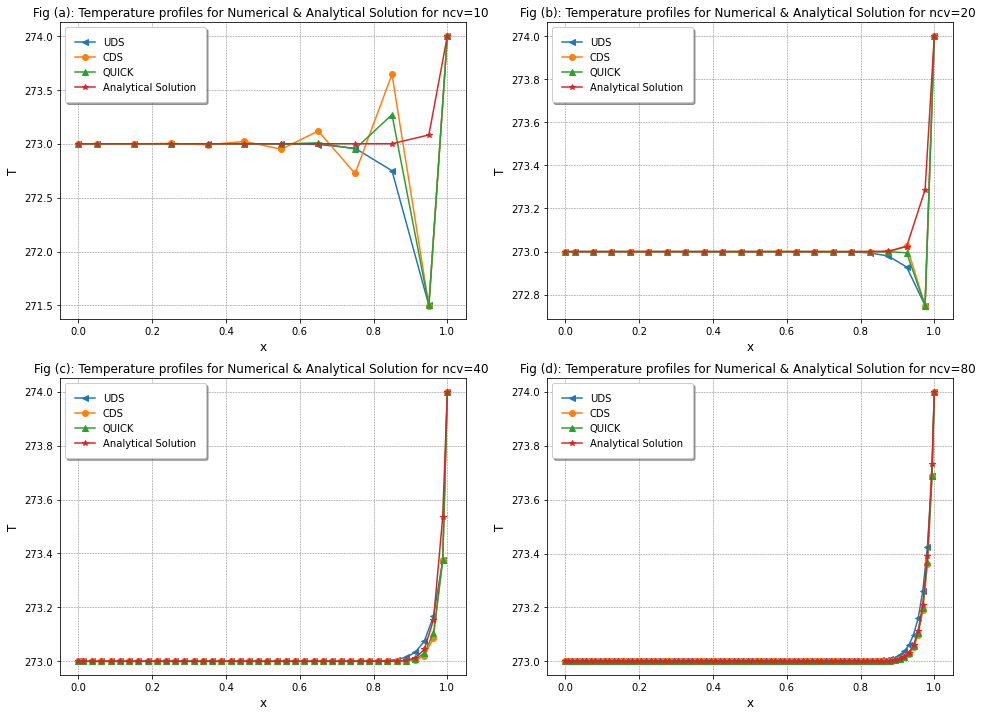

In [104]:
""" Plot for Comparison of Numerical solution with Exact solution """
%matplotlib inline

import matplotlib.pyplot as plt

fig = plt.figure(figsize =(16,12))
axes1 = fig.add_subplot(2,2,3)
axes2 = fig.add_subplot(2,2,4)
axes3 = fig.add_subplot(2,2,1)
axes4 = fig.add_subplot(2,2,2)

axes1.plot(xp_uds_40, T_uds_40 , marker = "<", label = "UDS")
axes1.plot(xp_cds_40, T_cds_40 , marker = "o", label = "CDS")
axes1.plot(xp_quick_40, T_quick_40 , marker = "^", label = "QUICK")
axes1.plot(xp_uds_40, T_exact_40 , marker = "*", label = "Analytical Solution")
axes1.set_xlabel('x',fontsize = 12)
axes1.set_ylabel('T',fontsize = 12)
axes1.set_title('Fig (c): Temperature profiles for Numerical & Analytical Solution for ncv=40 ',fontsize = 12)
axes1.grid(True)
axes1.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes1.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

axes2.plot(xp_uds_80, T_uds_80 , marker = "<", label = "UDS")
axes2.plot(xp_cds_80, T_cds_80 , marker = "o", label = "CDS")
axes2.plot(xp_quick_80, T_quick_80 , marker = "^", label = "QUICK")
axes2.plot(xp_uds_80, T_exact_80 , marker = "*", label = "Analytical Solution")
axes2.set_xlabel('x',fontsize = 12)
axes2.set_ylabel('T',fontsize = 12)
axes2.set_title('Fig (d): Temperature profiles for Numerical & Analytical Solution for ncv=80 ',fontsize = 12)
axes2.grid(True)
axes2.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes2.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

axes3.plot(xp_uds_10, T_uds_10 , marker = "<", label = "UDS")
axes3.plot(xp_cds_10, T_cds_10 , marker = "o", label = "CDS")
axes3.plot(xp_quick_10, T_quick_10 , marker = "^", label = "QUICK")
axes3.plot(xp_uds_10, T_exact_10 , marker = "*", label = "Analytical Solution")
axes3.set_xlabel('x',fontsize = 12)
axes3.set_ylabel('T',fontsize = 12)
axes3.set_title('Fig (a): Temperature profiles for Numerical & Analytical Solution for ncv=10 ',fontsize = 12)
axes3.grid(True)
axes3.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes3.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

axes4.plot(xp_uds_20, T_uds_20 , marker = "<", label = "UDS")
axes4.plot(xp_cds_20, T_cds_20 , marker = "o", label = "CDS")
axes4.plot(xp_quick_20, T_quick_20 , marker = "^", label = "QUICK")
axes4.plot(xp_uds_20, T_exact_20 , marker = "*", label = "Analytical Solution")
axes4.set_xlabel('x',fontsize = 12)
axes4.set_ylabel('T',fontsize = 12)
axes4.set_title('Fig (b): Temperature profiles for Numerical & Analytical Solution for ncv=20 ',fontsize = 12)
axes4.grid(True)
axes4.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
axes4.legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

### Discussion on Case (a) - For 10 control volumes

The analytical solution shows that the temperature slowly increases from 273K on the west boundary to 274K on the east boundary. 
For implicit time integration scheme , the restriction on the grid resolution to keep the coefficients on $T_{E}$ and $T_{W}$ negative can be represented as:
 $$  \frac{u\Delta x}{\alpha} \le 2 $$
 For ncv = 10, $\Delta x$ = 0.10 and the value of  $$\frac{u\Delta x}{\alpha} = 5 $$

So when we discretize the domain with 10 control volumes, the restriction on spatial resolution is not satisfied i.e. it is not ensured that the coefficients of $T_{E}$ and $T_{W}$ will have the correct sign.Consider the formula for $a_E$:
$$ a_E = - D_e + \frac{1}{2}c_p\dot{m}_e\left(1 - \alpha_e \right) $$
For flow in the positive direction , at the right boundary, we have set $\alpha_e$ = -1, as such, $$ a_E = - D_e + c_p\dot{m}_e $$ So, Depending on the grid (through $D_e$ since $$ D_e = \frac{kA_e}{\Delta x_PE} $$), the value of $a_E$ could become positive. 
As such, all the three schemes show instability when discretized using 10 control volumes

### Discussion on Case (b), (c) and (d) - For 20, 40 and 80 control volumes respectively

We know, in order to have a stable, oscillation-free solution, both spatial and temporal grid restrictions need to be satisfied. As we use an implicit time integratin scheme, the coeffcient on $T_{P}$ cannot be negative assuming mass is well conserved i.e. no timestep restriction, but the restriction on grid resolution still prevails to ensure that coefficients of $T_{E}$ and $T_{W}$ are negative. 
 
 For ncv = 20, $\Delta x$ = 0.05 and the value of  $$\frac{u\Delta x}{\alpha} = 2.5 $$
 For ncv = 40, $\Delta x$ = 0.025 and the value of  $$\frac{u\Delta x}{\alpha} = 1.25 $$
 For ncv = 80, $\Delta x$ = 0.0125 and the value of  $$\frac{u\Delta x}{\alpha} = 0.625 $$
 
As explained for Case (a), for Case (b) also the spatial grid restriction is not satisfied, hence depending on the grid and value of $\alpha_e$ the coefficient of $T_{E}$ and $T_{W}$ may take up the wrong sign as such, wiggles still remain in the temperature profile. But for Case (c) and (d) with ncv = 40 and 80, the value of $\Delta x$ is small enough that the spatial grid restriction is satisfied, hence the solution is stable and oscillation-free. 

Furthermore, it is to note that for CDS and QUICK, more iterations are required for the solution to converge because these two schemes were implemented using the deferred correction approach i.e. the linearization was based on a lower order (UDS) scheme and thus it was inexact. But once the solution converged, that became irrelevant since the fluxes were computed based on the Higher Order Scheme. 
